# CV07. Stereo camera - Weak calibration

Input: pair(s) of images from 2 camera view on the same scene

Output: Disparty map

- Bước 1: Tìm các cặp điểm đặc trưng trong ảnh (DoG detector)
- Bước 2: Sơ khớ các điểm ảnh để tìm đc các cặp điểm tương đồng
- Bước 3: Tìm ma trận F ==> có thể Xác định các epipolarline
- Bước 4: Thực hiện rectify 2 ảnh sử dụng ma trận F, xem hàm: stereoRectifyUncalibrated
- Bước 5: Stereo matching và tính disparity: phương pháp StereoSGBM 


In [1]:
# Các thư viện cần thiết
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

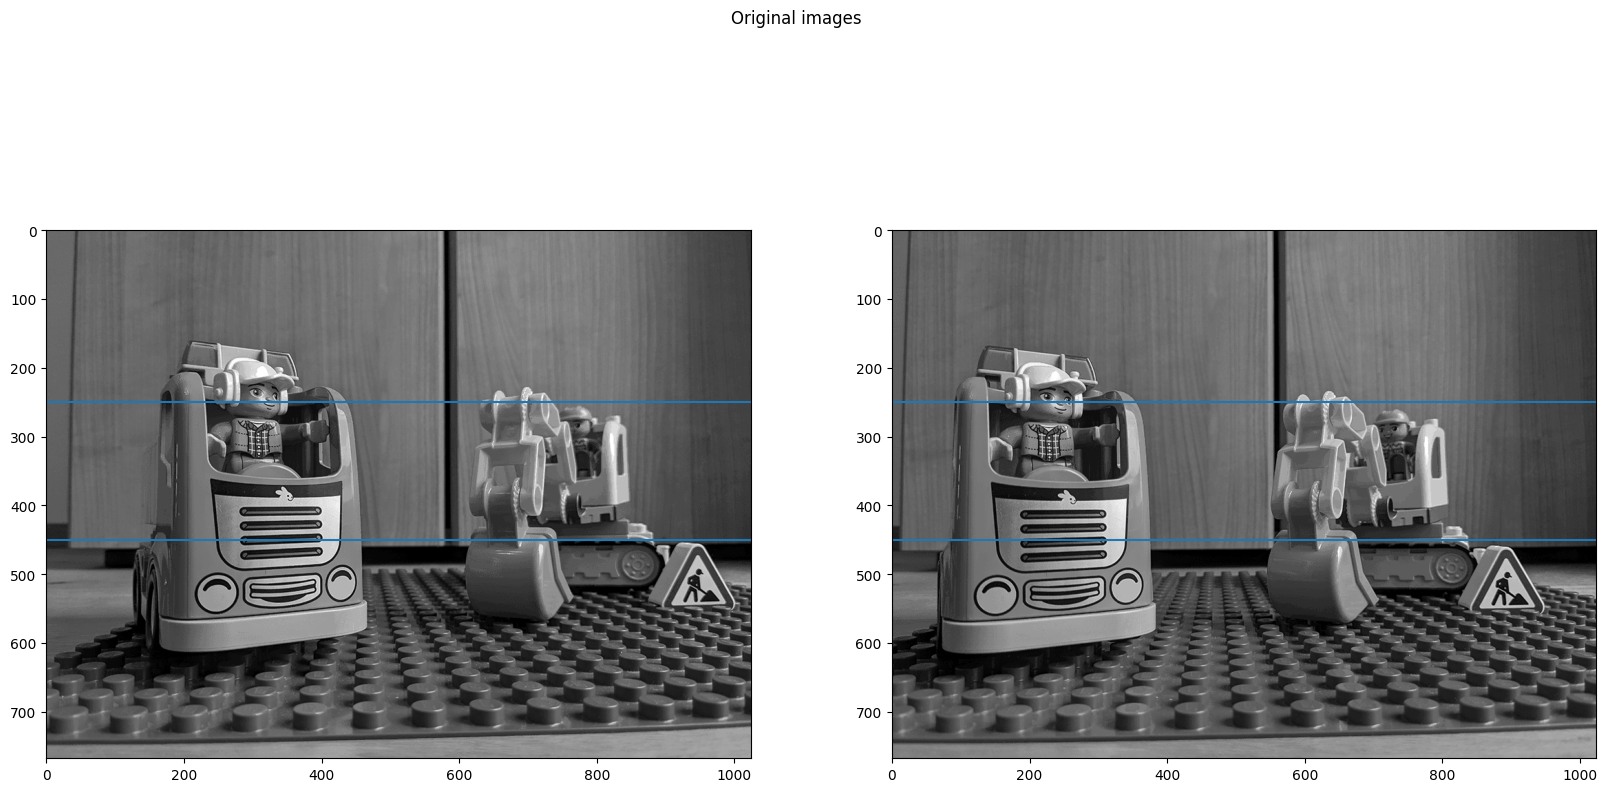

In [2]:
# 0. Read both images and convert to grayscale

img_name1='wk_calib_data/left_img.png' #uncalibrated camera
img_name2='wk_calib_data/right_img.png' #uncalibrated camera

img1 = cv.imread(img_name1, cv.IMREAD_GRAYSCALE)
img2 = cv.imread(img_name2, cv.IMREAD_GRAYSCALE)

# ------------------------------------------------------------
# PREPROCESSING

# Compare unprocessed images
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img1, cmap="gray")
axes[1].imshow(img2, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Original images")
plt.show()

# Tìm các cặp điểm tương đồng giữa 2 ảnh

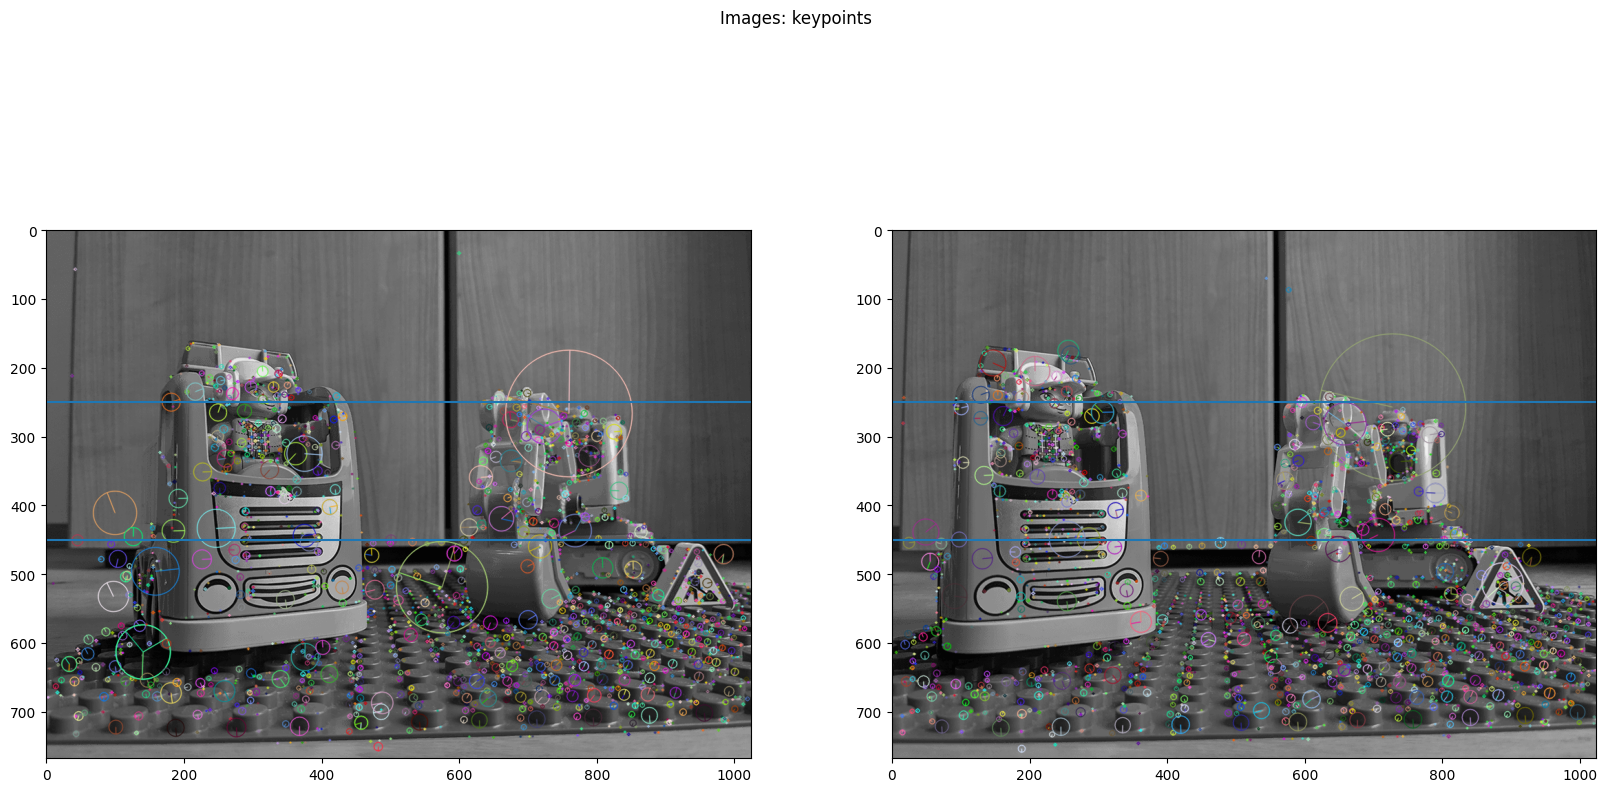

In [4]:
# 1. Phát hiện các điểm đặc trưng và đặc trưng cục bộ trên 2 ảnh. Đặc trưng sử dụng: SIFT, SURF, ..

# 1. Detect keypoints and their descriptors
# Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html

# YOUR CODE HERE 
# keypoints and their discriptors on each image
kp1, des1 = cv.SIFT_create().detectAndCompute(img1, None)
kp2, des2 = cv.SIFT_create().detectAndCompute(img2, None)
# YOUR CODE HERE

# Visualize keypoints
imgKP_1 = cv.drawKeypoints(
    img1, kp1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

imgKP_2 = cv.drawKeypoints(
    img2, kp2, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(imgKP_1, cmap="gray")
axes[1].imshow(imgKP_2, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Images: keypoints")
plt.show()

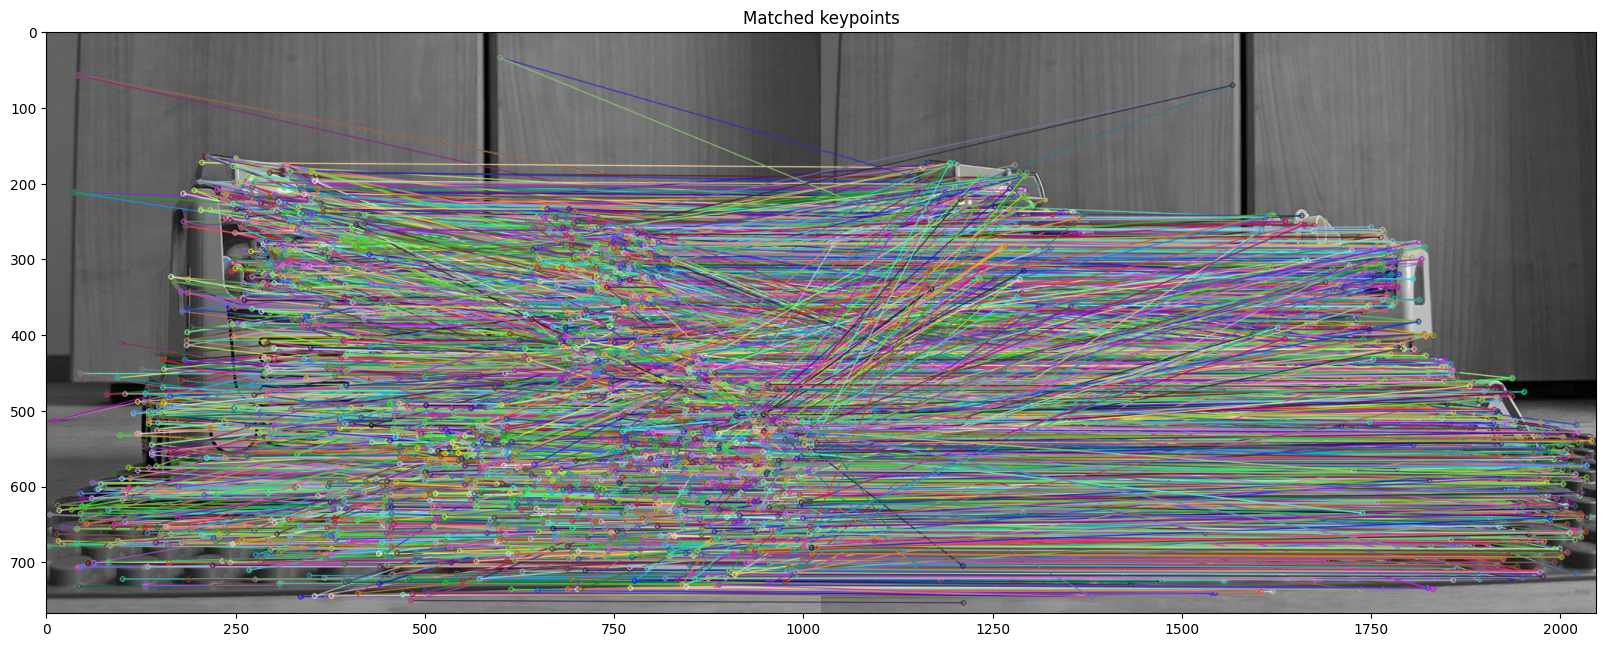

In [5]:
# 2. So khớp cấc điểm đặc trưng giữa 2 ảnh
# 2. Match keypoints in both images
# Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html

pts1 = [] # các cặp điểm được sơ khớp tương ứng từ 2 ảnh
pts2 = [] # các cặp điểm được sơ khớp tương ứng từ 2 ảnh
# tìm các cặp điểm so khớp từ 2 ảnh và add tương ứng vao pts1 và pts2
# YOUR CODE HERE
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

for m, n in matches:
    if m.distance < 0.75 * n.distance:
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

# YOUR CODE HERE

# Visualize matched keypoints
imgMatched = cv.drawMatchesKnn(
    img1, kp1, img2, kp2, matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20, 10))
plt.imshow(imgMatched)
plt.title("Matched keypoints")
plt.show()



# Draw the keypoint matches between both pictures



# Calibration

In [7]:
# 3. Tìm ma trận F
# Calculate the fundamental matrix for the cameras
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

# Calculate the fundamental matrix for the corresponding points pts1, pts2. Xem hàm: findFundamentalMat

# YOUR CODE HERE
fundamental_matrix = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)

inliers = fundamental_matrix[1]
fundamental_matrix = fundamental_matrix[0]

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

In [8]:
# Fundamental Matrix
print("Fundamental Matrix:")
print(fundamental_matrix)

Fundamental Matrix:
[[-2.31040786e-08 -1.24945416e-05  7.46607915e-03]
 [ 1.35981829e-05 -1.71432064e-06 -7.33191251e-02]
 [-8.01534763e-03  7.28772459e-02  1.00000000e+00]]


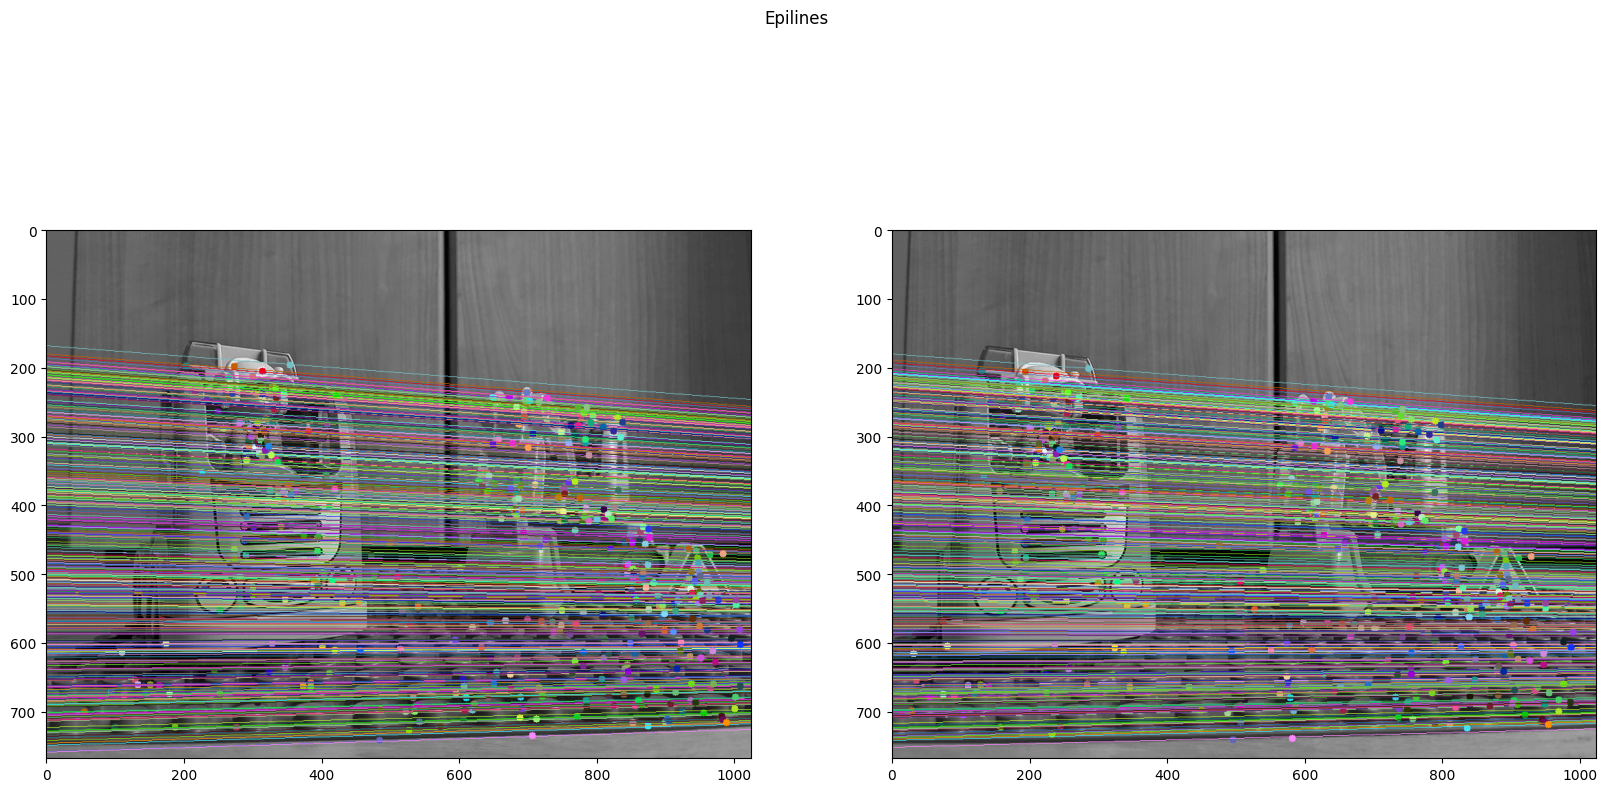

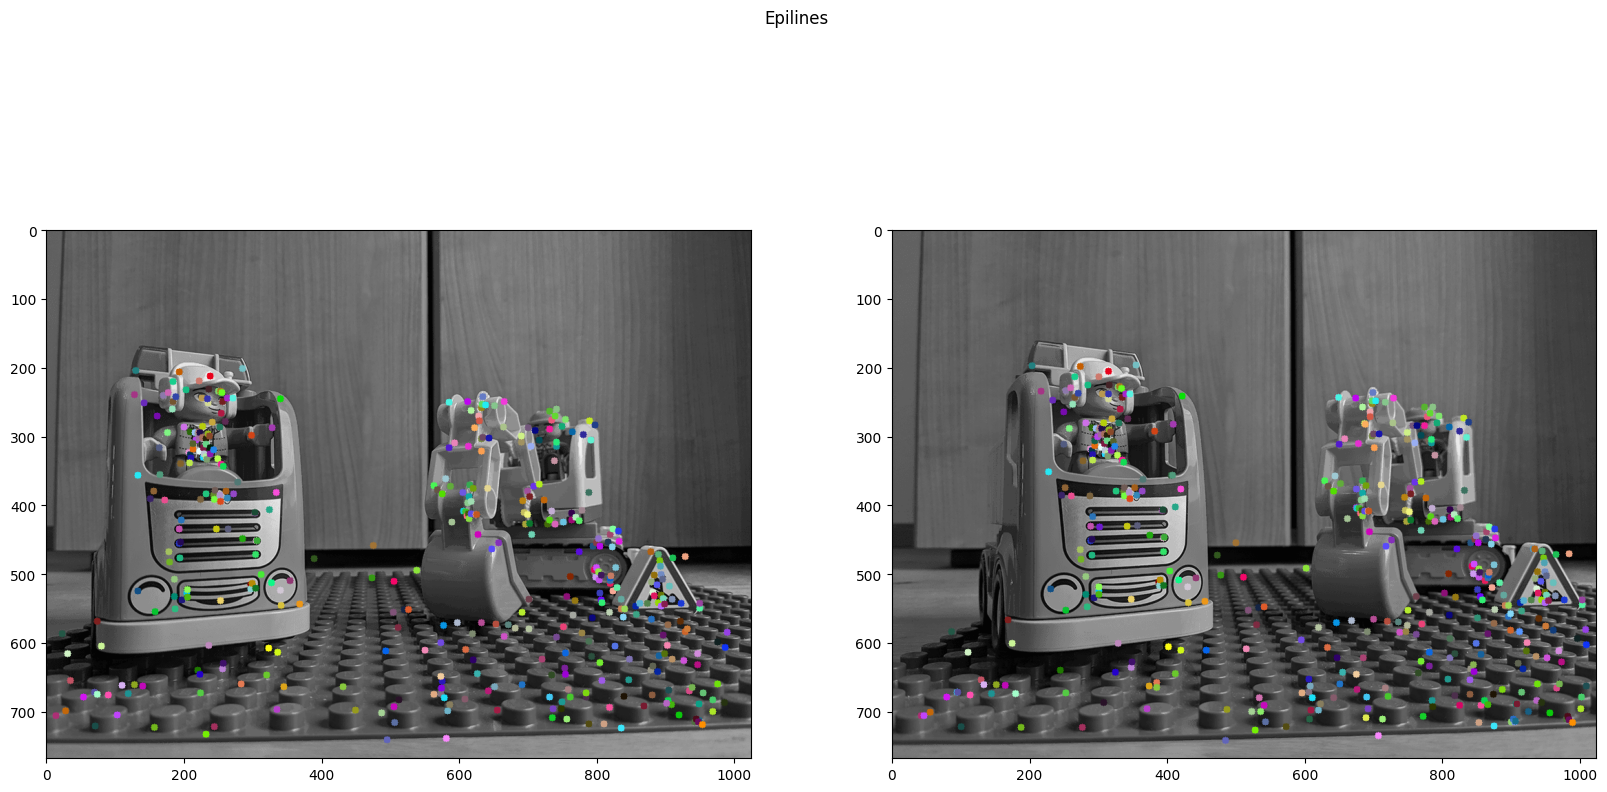

In [9]:
# Visualize epilines
# Adapted from: https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
def drawlines(img1src, img2src, lines, pts1src, pts2src):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c = img1src.shape
    img1color = cv.cvtColor(img1src, cv.COLOR_GRAY2BGR)
    img2color = cv.cvtColor(img2src, cv.COLOR_GRAY2BGR)
    # Edit: use the same random seed so that two images are comparable!
    np.random.seed(0)
    for r, pt1, pt2 in zip(lines, pts1src, pts2src):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1color = cv.line(img1color, (x0, y0), (x1, y1), color, 1)
        img1color = cv.circle(img1color, tuple(pt1), 5, color, -1)
        img2color = cv.circle(img2color, tuple(pt2), 5, color, -1)
    return img1color, img2color


# Find epilines corresponding to points in right image (second image)
lines1 = cv.computeCorrespondEpilines(
    pts2.reshape(-1, 1, 2), 2, fundamental_matrix)
lines1 = lines1.reshape(-1, 3)

# drawing its lines on left image
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) 

lines2 = cv.computeCorrespondEpilines(
    pts1.reshape(-1, 1, 2), 1, fundamental_matrix)
lines2 = lines2.reshape(-1, 3)


# drawing its lines on right image

img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img5)
axes[1].imshow(img3)
plt.suptitle("Epilines")
plt.show()


# Display both images with epilines
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img6)
axes[1].imshow(img4)
plt.suptitle("Epilines")
plt.show()


In [10]:
# 4. Stereo rectification (uncalibrated variant)
# Adapted from: https://stackoverflow.com/a/62607343
h1, w1 = img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1)
)

print ('Homography matrix for the left image H1:')
print(H1)
print ('Homography matrix for the right image H2:')
print(H2)

Homography matrix for the left image H1:
[[-6.87000867e-02 -1.33191999e-02  7.30017198e+00]
 [ 8.84752583e-03 -7.30931384e-02 -5.42177144e+00]
 [ 1.49838171e-05 -1.32329786e-06 -8.11225533e-02]]
Homography matrix for the right image H2:
[[ 9.01584159e-01  3.70396504e-02  3.61656848e+01]
 [-1.14227983e-01  9.96150733e-01  5.99628460e+01]
 [-1.90572280e-04 -7.82925314e-06  1.10057944e+00]]


In [11]:
# rectify the left image 
img1_rectified = cv.warpPerspective(img1, H1, (w1, h1))

# rectify the right image 
# YOUR CODE HERE
img2_rectified = cv.warpPerspective(img2, H2, (w2, h2))



cv.imwrite("rectified_1.png", img1_rectified)
cv.imwrite("rectified_2.png", img2_rectified)

True

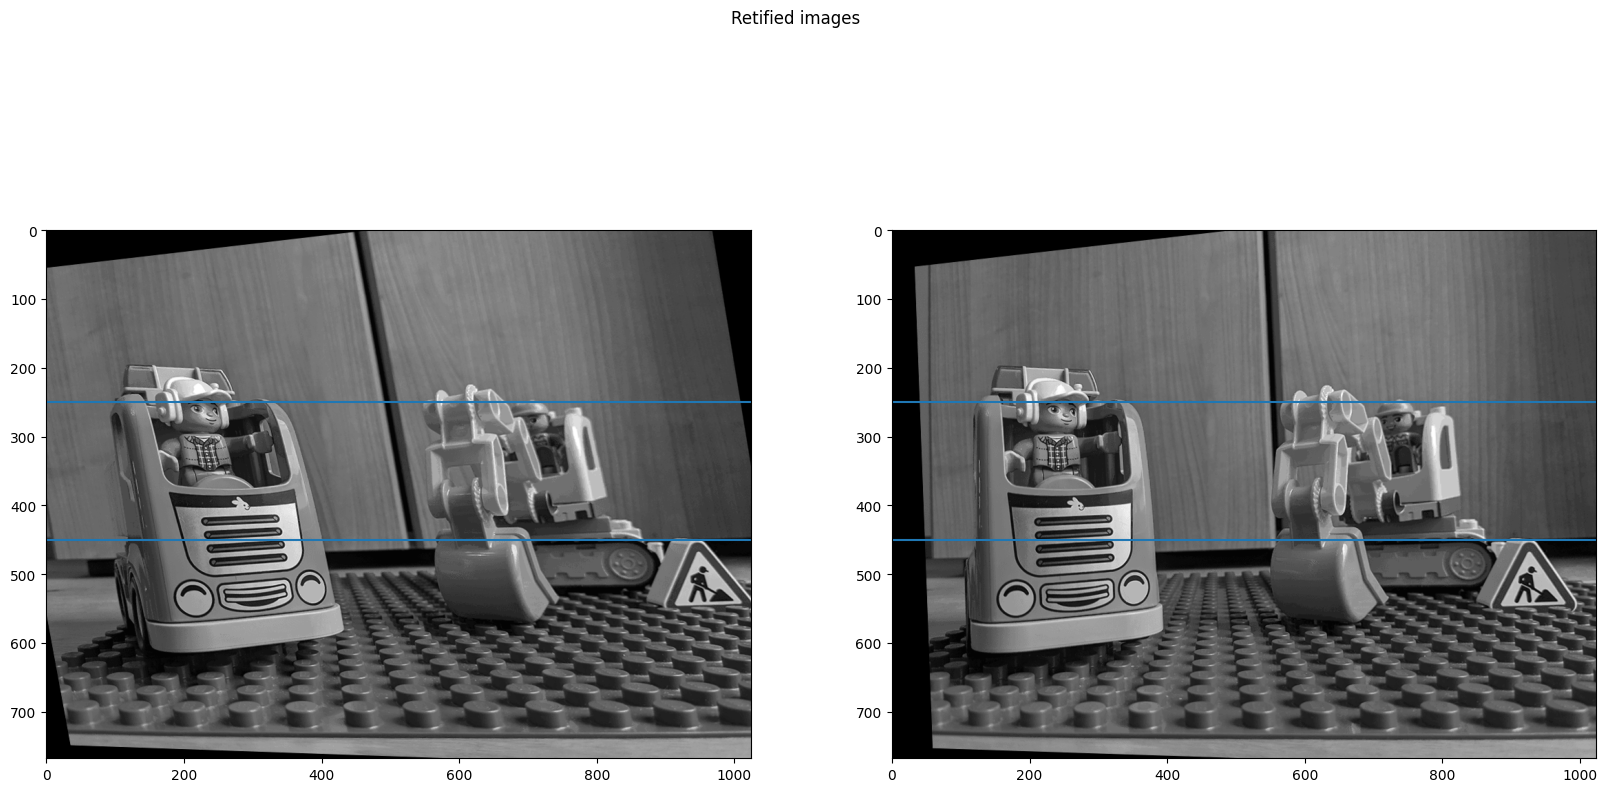

In [12]:
# Display rectified images
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img1_rectified, cmap="gray")
axes[1].imshow(img2_rectified, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Retified images")
plt.show()

# 3D estimation: Stereo Matching for the Disparity Map

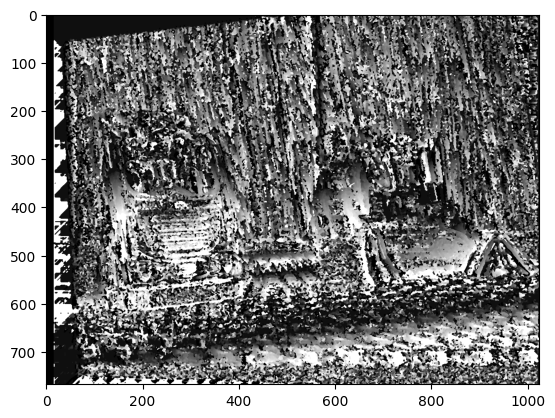

In [13]:
# Sử dụng phương pháp StereoSGBM để tính Disparity Map
# ------------------------------------------------------------
# CALCULATE DISPARITY (DEPTH MAP)
# Ref: https://github.com/opencv/opencv/blob/master/samples/python/stereo_match.py
# and: https://docs.opencv.org/master/dd/d53/tutorial_py_depthmap.html

## YOUR CODE HERE
# Stereo matching : using SGBM. StereoSGBM Parameter explanations:  https://docs.opencv.org/4.5.0/d2/d85/classcv_1_1StereoSGBM.html

disparity_SGBM = cv.StereoSGBM_create( minDisparity=0)
disparity_SGBM = disparity_SGBM.compute(img1_rectified, img2_rectified).astype(np.float32) / 16.0

 
# compute disparity


# Normalize the values to a range from 0..255 for a grayscale image
disparity_SGBM = cv.normalize(disparity_SGBM, disparity_SGBM, alpha=255,
                              beta=0, norm_type=cv.NORM_MINMAX)
disparity_SGBM = np.uint8(disparity_SGBM)

cv.imwrite("disparity_SGBM_norm.png", disparity_SGBM)

## YOUR CODE HERE

plt.imshow(disparity_SGBM, cmap="gray")

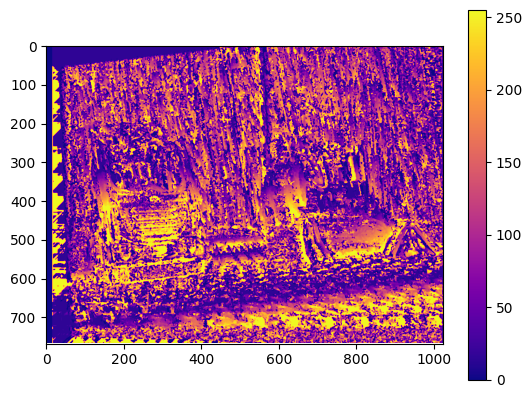

In [14]:
plt.imshow(disparity_SGBM, cmap='plasma')
plt.colorbar()
plt.show()

Adapted from: https://www.andreasjakl.com/understand-and-apply-stereo-rectification-for-depth-maps-part-2/